# 1. Import 

In [1]:
import os
import napari
import tifffile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

from pathlib import Path
from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel
from napari.utils.notebook_display import nbscreenshot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


# 2. Load frames 

In [ ]:
homeFolder = '/media/raphael/data/works/20231220_C3_14_2h_ofON/'
nameKey = 'C3.14_ON_01_w1SPI-488_s'

imsQ = '4'
cellNumber = '38'

In [2]:
# hard-code the paths of our input and output directories
path_input =  "/media/raphael/data/works/20231220_C3_14_2h_ofON/C3.14_ON_01_w1SPI-488_s4/cell_38/" #repertoire contenant les images
path_output = "/media/raphael/data/works/20231220_C3_14_2h_ofON/C3.14_ON_01_w1SPI-488_s4/cell_38/" + "/output" #repertoire dans lequel on va enregistrer les resultats de detection


In [3]:
file_name = os.listdir(path=Path(path_input))
file_name =  sorted(file_name)

full_film = imr(path_input + "*.tif")
full_film = np.max(full_film, axis=1)

In [4]:
full_film

dask.array<amax-aggregate, shape=(120, 173, 184), dtype=uint16, chunksize=(1, 173, 184), chunktype=numpy.ndarray>

# 3.Parameters  

In [5]:
voxelRadius = (600, 110, 110)
objectRadius = (600, 105, 105)

# 4.Load 3D stack

In [6]:
selectedThreshold = int(input("Enter your selected threshold: "))

Enter your selected threshold: 45


# Get a list of spot 

In [9]:
images=[]    
spots_list=[]

spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=voxelRadius, 
    object_radius_nm=objectRadius, 
    ndim=3)

for t in range(1,121,1):

    path = os.path.join(path_input, "C3.14_ON_01_w1SPI-488_s4_cell_38"+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)
    images.append(rna)

n=len(images)
print("Total number of images : "+str(n))

for rna in images:
    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
    spots_list.append(spots_)

    
print('done')

Total number of images : 120
done


In [10]:
images[0].shape

(36, 173, 184)

# Get histogram 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.io import imread
from skimage.exposure import histogram

<IPython.core.display.Javascript object>


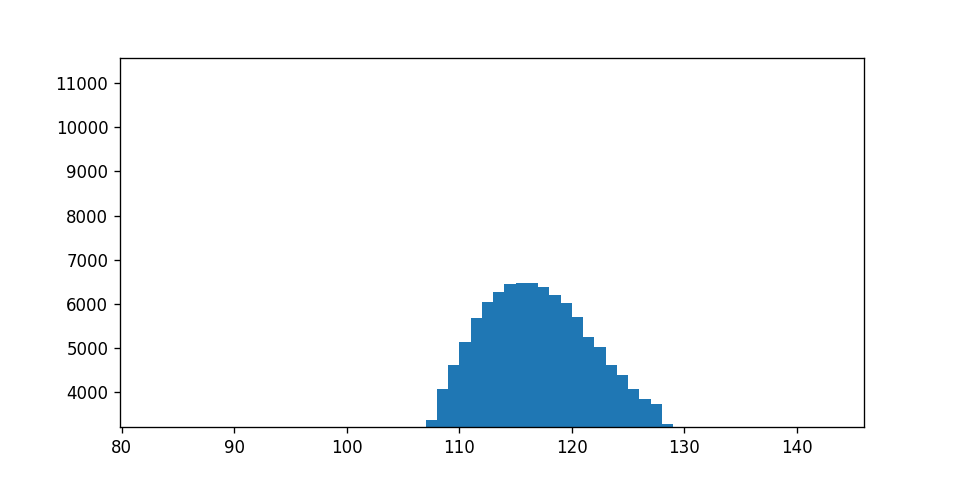

<BarContainer object of 530 artists>

In [12]:
plt.figure(figsize=(8,4)) # Create an empty figure with a specific screen size
pixel_counts, pixel_values = histogram(images[2]) # Calculate the image histogram
plt.bar(pixel_values, pixel_counts, width=2) # Plot the histogram

# Build Ref spot 

In [13]:
from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ, reorderZstack

image list found!
Found 18524
Found 18524 spots, max intensity = 122


<IPython.core.display.Javascript object>


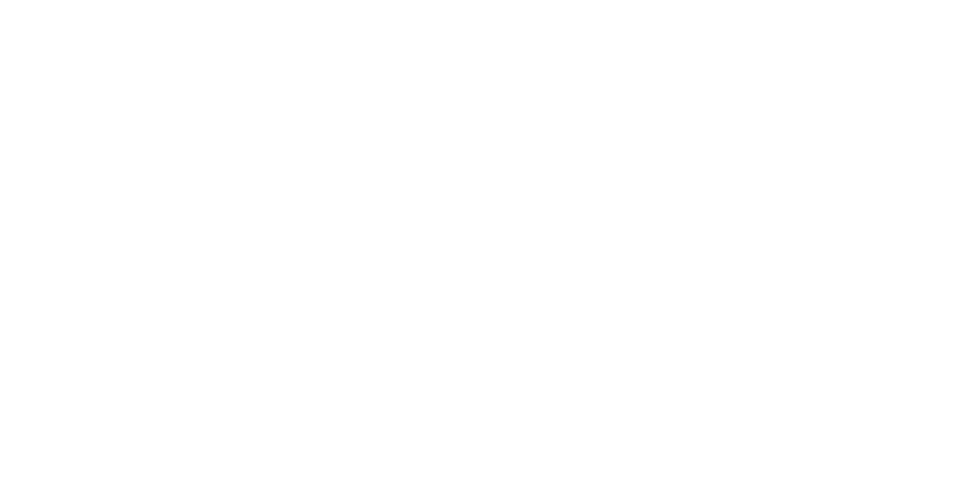

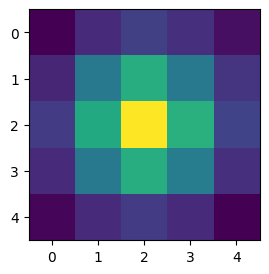

In [14]:
reference_spot = buildReferenceSpotFromImages(images, spots_list, alpha=0.2, gamma=5, voxelSize=voxelRadius, objectSize=objectRadius)
%matplotlib inline
plt.figure(num=3,figsize=(3,3))
plt.imshow(np.max(reference_spot, axis=0))
refSpot = deepcopy(reference_spot)

# 5. Spot detection 

In [15]:
spotsFrame, clustersFrames, ThresholdFrames = getSpotAndClusters(path_input, 
                                                                 reference_spot, 
                                                                 cellnumber="", 
                                                                 startTime=1,
                                                                 stopTime=11, 
                                                                 thresholdManual=selectedThreshold, 
                                                                 beta=1.5, 
                                                                 gamma=5,
                                                                 numberOfSpots=2,
                                                                 radiusCluster=700, 
                                                                 voxelSize=voxelRadius, 
                                                                 objectSize=objectRadius,
                                                                 extensionMov='.tif')

FileNotFoundError: [Errno 2] No such file or directory: '/media/raphael/data/works/20231220_C3_14_2h_ofON/C3.14_ON_01_w1SPI-488_s4/cell_38/C3.14_ON_01_w1SPI-488_s4_t001.tif'

# 6. Decompose dense regions 

# 7. Detect clusters 

## 7.1 Set parameter and  Detect clusters

In [34]:
#parametres pouvant influer sur le nombre de TS detecte 
cs_radius = 500
cs_min_spots = 3 # 8 


In [35]:
def define_clusters(spots_post_decomposition):
    spots_post_clustering, clusters = detection.detect_clusters(
        spots=spots_post_decomposition, 
        voxel_size=(voxel_z, voxel_xy, voxel_xy), 
        radius=cs_radius, 
        nb_min_spots=cs_min_spots)
    print("detected spots after clustering")
    print("\r shape: {0}".format(spots_post_clustering.shape))
    print("\r dtype: {0}".format(spots_post_clustering.dtype), "\n")
    print("detected clusters")
    print("\r shape: {0}".format(clusters.shape))
    print("\r dtype: {0}".format(clusters.dtype))

    return clusters

In [36]:
clusters = []

for points in spots_post_decomposition: 
    cls = define_clusters(points)
    print('clusters : \n ', cls)
    clusters.append(cls)

detected spots after clustering
 shape: (15303, 4)
 dtype: int64 

detected clusters
 shape: (882, 5)
 dtype: int64
clusters : 
  [[  0 643 861   4   0]
 [  1 833 635   3   1]
 [  3 624 863   4   2]
 ...
 [ 27 427 586   3 879]
 [ 28 466 593   3 880]
 [ 28 975 654   3 881]]
detected spots after clustering
 shape: (15828, 4)
 dtype: int64 

detected clusters
 shape: (928, 5)
 dtype: int64
clusters : 
  [[   0  659  881    3    0]
 [   0  666  879    3    1]
 [   0  685  870    6    2]
 ...
 [  26 1033  614    3  925]
 [  26 1075  819    4  926]
 [  27 1137  141    3  927]]
detected spots after clustering
 shape: (12403, 4)
 dtype: int64 

detected clusters
 shape: (677, 5)
 dtype: int64
clusters : 
  [[   1  909  658    4    0]
 [   8  973  478    3    1]
 [  11  379  811    5    2]
 ...
 [  28  375  582    3  674]
 [  28  645  648    3  675]
 [  30  835 1044    3  676]]
detected spots after clustering
 shape: (9825, 4)
 dtype: int64 

detected clusters
 shape: (426, 5)
 dtype: int64
clu

## 7.2 Clean clusters 

In [39]:
from alive_progress import alive_bar
import time
def order_clusters_frames(clustersFrames,mipSequenceCell,threshold ):

    res = []
    with alive_bar(len(clustersFrames), title = "order cluster frame",force_tty=True) as bar :
        for i in range(len(clustersFrames)):
            #print('clustersFrames', i)
            frame = clustersFrames[i]
            tmp =[]
            id = 0
            for j in range(len(frame)):
                y_coord = frame[j][1]
                x_coord = frame[j][2]

                test = np.array(mipSequenceCell[i][y_coord:y_coord+1,x_coord:x_coord+1])
                val = test[0][0]

                tmp.append(val)

            try :
                # possibilite de rajouter une condition 
                # pour filtrer les sites de transcription uniquement en rajoutant un threshold de 1000
                if max(tmp) < threshold :
                    res.append([np.zeros(5)])
                else :
                    index_max = tmp.index(max(tmp))
                    #print(max(tmp), index_max)
                    #print(frame)
                    res.append([frame[index_max]])

            except ValueError as e:
                res.append([np.zeros(5)])
            time.sleep(0.1)
            bar()
        
    
        return res 
        
            

In [40]:
a = order_clusters_frames(clusters,mipSequenceCell,800)

order cluster frame |████████████████████████████████████████| 10/10 [100%] in 6


# 8. Visualize results 

In [49]:
def getDetectedPointsForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-1])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:]
    return pts_coords

def getDetectedClustersForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-3])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:3]
    return pts_coords

def set_pts_features(pts_layer, cls_layer, pts_coordinates, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrame(cluster_coordinate,frameNumber)


pts_coordinates = spotsFrame
cluster_coordinate = clustersFrames
mipSequenceCell = full_film

viewer = napari.Viewer()
image_layer = viewer.add_image(
        mipSequenceCell, colormap='green' #maxImageCell
        )
if image_layer.data.ndim == 4:
    bigfishSpots = spotsFrame
elif image_layer.data.ndim == 3:
    bigfishSpots = getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2))
    
bigfish_Spots = viewer.add_points(
        getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=4,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots'
        )

bigfish_clusters = viewer.add_points(
        getDetectedClustersForFrame(cluster_coordinate,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        symbol='diamond',
        name = 'bigFish Clusters'
        )

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_Spots, bigfish_clusters, pts_coordinates, cluster_coordinate, event.value)
        )

<function __main__.<lambda>(event)>